# DistilBERT Evaluation on ISOT Dataset

## Introduction

This notebook evaluates a fine-tuned DistilBERT model on two distinct fake news detection scenarios:
1. **Titles-only dataset**: Using only article headlines
2. **Full-text dataset**: Using complete articles with both titles and text

This dual evaluation approach provides insights into how well DistilBERT performs with limited context versus full article context, which is particularly valuable for understanding deployment tradeoffs in real-world scenarios where processing speed or data availability might be constraints.

## 1. Setting Up the Environment

Let's start by importing all necessary libraries and setting up utility functions to monitor resource usage:

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import psutil
import gc
import re

These core libraries provide the foundation for data manipulation, model evaluation, and resource monitoring - especially important for edge deployment scenarios.

In [2]:
# Import model and evaluation libraries
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

These specialized libraries enable us to work with the DistilBERT model and evaluate its performance using standard metrics.

In [3]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

Visualization tools will help us understand and communicate performance results more effectively.

In [4]:
# Set device - using CPU for edge device testing
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


I deliberately chose to use the CPU rather than GPU for this evaluation because:
1. The primary target for edge deployment is devices that typically lack dedicated GPUs
2. CPU performance metrics provide a more realistic assessment of real-world deployment scenarios
3. This enables direct comparison with other lightweight models (TinyBERT, MobileBERT) in similar conditions

In [5]:
# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

print(f"Starting memory usage: {get_memory_usage():.2f} MB")

Starting memory usage: 819.23 MB


This utility function tracks the resident set size (RSS) of the Python process, providing a reliable measure of actual memory consumption during model loading and inference. This is crucial for understanding deployability on resource-constrained devices.

## 2. Loading the Pre-trained Model

Now I'll load the DistilBERT model that was previously fine-tuned on the ISOT dataset:

In [6]:
# Load the pre-trained DistilBERT model
print("\nLoading model...")
model_path = "../ml_models/distilbert-fake-news-detector"


Loading model...


In [7]:
# Initialize tokenizer
start_time = time.time()
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

In [8]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)  # Move to CPU
load_time = time.time() - start_time

In [9]:
print(f"Model loaded in {load_time:.2f} seconds")
print(f"Memory usage after loading model: {get_memory_usage():.2f} MB")

Model loaded in 0.04 seconds
Memory usage after loading model: 832.38 MB


Model loading time and memory footprint are critical metrics for edge deployment scenarios. By measuring these values, we can determine whether DistilBERT is suitable for resource-constrained environments or if a smaller alternative like TinyBERT would be more appropriate.

## 3. Data Loading and Preparation

Next, I'll load various data sources for our evaluation:

In [10]:
# Load all data sources
print("\nLoading all data sources...")


Loading all data sources...


In [11]:
# 1. Load titles_only_real.csv (real news, titles only)
try:
    titles_only_real_df = pd.read_csv('../data/titles_only_real.csv')
    # Ensure label is 1 for real news
    titles_only_real_df['label'] = 1
    print(f"Loaded {len(titles_only_real_df)} real news titles from titles_only_real.csv")
except Exception as e:
    print(f"Error loading titles_only_real.csv: {e}")
    titles_only_real_df = pd.DataFrame(columns=['title', 'label'])

Loaded 299 real news titles from titles_only_real.csv


In [12]:
# 2. Load FakeNewsNet (fake news only)
try:
    fake_news_net_df = pd.read_csv('./datasets/simplified_FakeNewsNet.csv')
    # Keep only fake news
    fake_news_net_df = fake_news_net_df[fake_news_net_df['label'] == 0]
    print(f"Loaded {len(fake_news_net_df)} fake news articles from FakeNewsNet")
except Exception as e:
    print(f"Error loading FakeNewsNet: {e}")
    fake_news_net_df = pd.DataFrame(columns=['title', 'label'])

Loaded 5755 fake news articles from FakeNewsNet


In [13]:
# 3. Load fake_news_evaluation.csv (fake news with text)
try:
    fake_news_eval_df = pd.read_csv('./datasets/fake_news_evaluation.csv')
    # Ensure label is 0 for fake news
    fake_news_eval_df['label'] = 0
    print(f"Loaded {len(fake_news_eval_df)} fake news articles from fake_news_evaluation.csv")
except Exception as e:
    print(f"Error loading fake_news_evaluation.csv: {e}")
    fake_news_eval_df = pd.DataFrame(columns=['title', 'text', 'label'])

Loaded 21 fake news articles from fake_news_evaluation.csv


In [14]:
# 4. Load manual_real.csv (real news with text)
try:
    manual_real_df = pd.read_csv('./datasets/manual_real.csv')
    # Ensure label is 1 for real news
    manual_real_df['label'] = 1
    print(f"Loaded {len(manual_real_df)} real news articles with text from manual_real.csv")
except Exception as e:
    print(f"Error loading manual_real.csv: {e}")
    manual_real_df = pd.DataFrame(columns=['title', 'text', 'label'])

Loaded 32 real news articles with text from manual_real.csv


I'm using a diverse set of data sources to create robust evaluation scenarios:
1. Title-only real news articles from handpicked sources
2. Fake news articles from FakeNewsNet repository
3. Manually curated fake news with full text for detailed evaluation
4. Manually curated real news with full text for balanced evaluation

This approach ensures our evaluation covers both headline-only and full-text scenarios, reflecting real-world detection challenges.

## 4. Preparing Title-Only Dataset

Now I'll prepare the title-only dataset for evaluation:

In [15]:
# Create title-only dataset
print("\nPreparing title-only dataset...")

# Get the target size (number of real news titles) for balancing
real_titles_count = len(titles_only_real_df)
print(f"Target size for balanced dataset: {real_titles_count} articles per class")


Preparing title-only dataset...
Target size for balanced dataset: 299 articles per class


In [16]:
# Prepare fake news data (titles only)
# 1. From FakeNewsNet
if 'text' not in fake_news_net_df.columns:
    fake_news_net_df['text'] = fake_news_net_df['title']
else:
    # Use only title as text
    fake_news_net_df['text'] = fake_news_net_df['title']

In [17]:
# 2. From fake_news_evaluation.csv
fake_news_eval_titles_df = fake_news_eval_df.copy()
fake_news_eval_titles_df['text'] = fake_news_eval_titles_df['title']  # Use only title, not full text

In [18]:
# Combine all fake news sources (titles only)
fake_news_title_only = pd.concat([fake_news_net_df[['text', 'label']], 
                                 fake_news_eval_titles_df[['text', 'label']]], 
                                 ignore_index=True)

In [19]:
# Balance fake news to match real news count
# This allows us to handle growing real news dataset without manual adjustment
if len(fake_news_title_only) > real_titles_count:
    print(f"Balancing fake news dataset: sampling {real_titles_count} articles from {len(fake_news_title_only)} total")
    # Sample randomly to match the real news count
    fake_news_title_only = fake_news_title_only.sample(n=real_titles_count, random_state=42)
else:
    print(f"Note: Not enough fake news articles ({len(fake_news_title_only)}) to match real news count ({real_titles_count})")

Balancing fake news dataset: sampling 299 articles from 5776 total


In [20]:
# Prepare real news data (titles only)
if 'text' not in titles_only_real_df.columns:
    titles_only_real_df['text'] = titles_only_real_df['title']

In [21]:
# Combine fake and real news (titles only)
title_only_dataset_df = pd.concat([fake_news_title_only, titles_only_real_df[['text', 'label']]], 
                                 ignore_index=True)

In [22]:
# Shuffle to mix real and fake news
title_only_dataset_df = title_only_dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
print(f"Prepared title-only dataset with {len(title_only_dataset_df)} articles")
print(f"Class distribution: {title_only_dataset_df['label'].value_counts().to_dict()}")

Prepared title-only dataset with 598 articles
Class distribution: {0: 299, 1: 299}


In [24]:
# Convert to HuggingFace Dataset format
title_only_dataset = HFDataset.from_pandas(title_only_dataset_df)

For the title-only dataset, I:
1. Ensure class balance by sampling an equal number of real and fake news titles
2. Create a standardized format with only text and label columns
3. Shuffle the data for unbiased evaluation
4. Convert to HuggingFace Dataset format for compatibility with transformers library

These steps enable fair evaluation of DistilBERT's performance on just headlines, which is particularly useful for applications that need to make quick assessments with minimal context.

## 5. Preparing Full-Text Dataset

Similarly, I'll prepare the full-text dataset:

In [25]:
# Create full-text dataset
print("\nPreparing full-text dataset...")


Preparing full-text dataset...


In [26]:
# Prepare fake news data (with full text)
# Use fake_news_eval_df which already has text
fake_news_full_text_df = fake_news_eval_df.copy()
fake_news_full_text_df['text'] = fake_news_full_text_df['title'] + " " + fake_news_full_text_df['text'].fillna('')

In [27]:
# Prepare real news data (with full text)
manual_real_text_df = manual_real_df.copy()
manual_real_text_df['text'] = manual_real_text_df['title'] + " " + manual_real_text_df['text'].fillna('')

In [28]:
# Balance the datasets if needed
fake_count = len(fake_news_full_text_df)
real_count = len(manual_real_text_df)
target_count = min(fake_count, real_count)

print(f"Full-text dataset - Fake: {fake_count}, Real: {real_count}")

Full-text dataset - Fake: 21, Real: 32


In [29]:
# Balance the datasets if needed
if fake_count > real_count:
    print(f"Balancing full-text dataset: sampling {real_count} fake articles from {fake_count}")
    fake_news_full_text_df = fake_news_full_text_df.sample(n=real_count, random_state=42)
elif real_count > fake_count:
    print(f"Balancing full-text dataset: sampling {fake_count} real articles from {real_count}")
    manual_real_text_df = manual_real_text_df.sample(n=fake_count, random_state=42)

Balancing full-text dataset: sampling 21 real articles from 32


In [30]:
# Combine fake and real news (with full text)
full_text_dataset_df = pd.concat([fake_news_full_text_df[['text', 'label']], 
                                manual_real_text_df[['text', 'label']]], 
                                ignore_index=True)

In [31]:
# Shuffle to mix real and fake news
full_text_dataset_df = full_text_dataset_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
print(f"Prepared full-text dataset with {len(full_text_dataset_df)} articles")
print(f"Class distribution: {full_text_dataset_df['label'].value_counts().to_dict()}")

Prepared full-text dataset with 42 articles
Class distribution: {1: 21, 0: 21}


In [33]:
# Convert to HuggingFace Dataset format
full_text_dataset = HFDataset.from_pandas(full_text_dataset_df)

For the full-text dataset, I follow a similar approach but:
1. Combine titles with article bodies to provide maximum context
2. Ensure perfect class balance for fair evaluation
3. Use manually curated articles to guarantee data quality
4. Create a smaller but higher-quality evaluation set

The full-text evaluation is critical for understanding DistilBERT's performance when given complete contextual information, which is more representative of thorough fake news detection systems.

## 6. Evaluation Utility Functions

Next, I'll define utility functions for evaluation:

In [34]:
# Define tokenization function
def tokenize_dataset(dataset):
    """Tokenize a dataset using the DistilBERT tokenizer"""
    print(f"Tokenizing dataset with {len(dataset)} examples...")
    tokenize_start_time = time.time()
    
    # Define tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors=None
        )
    
    # Clean dataset to handle edge cases
    def clean_dataset(example):
        example['text'] = str(example['text']) if example['text'] is not None else ""
        return example
    
    # Clean and tokenize
    cleaned_dataset = dataset.map(clean_dataset)
    tokenized_dataset = cleaned_dataset.map(tokenize_function, batched=True)
    tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    
    tokenize_time = time.time() - tokenize_start_time
    print(f"Dataset tokenized in {tokenize_time:.2f} seconds")
    print(f"Memory usage after tokenization: {get_memory_usage():.2f} MB")
    
    return tokenized_dataset

In [35]:
# Define model evaluation function - Part 1: Setup
def evaluate_model_setup(tokenized_dataset, dataset_name):
    """Evaluate the model on a tokenized dataset and return metrics and resource usage"""
    print(f"\nEvaluating model on {dataset_name} dataset...")
    
    # Reset all counters and lists
    all_preds = []
    all_labels = []
    total_inference_time = 0
    sample_count = 0
    inference_times = []
    memory_usages = []
    
    # Create DataLoader
    from torch.utils.data import DataLoader
    eval_dataloader = DataLoader(
        tokenized_dataset, 
        batch_size=16,  # Appropriate batch size for CPU
        shuffle=False
    )
    
    print(f"Starting evaluation on {len(tokenized_dataset)} examples")
    
    return eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

In [36]:
# Define model evaluation function - Part 2: Inference loop
def run_evaluation_loop(eval_dataloader, all_preds, all_labels, total_inference_time, 
                       sample_count, inference_times, memory_usages):
    """Run the evaluation loop on the provided dataloader"""
    
    # Evaluation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(eval_dataloader):
            # Track batch progress
            if batch_idx % 5 == 0:
                print(f"Processing batch {batch_idx}/{len(eval_dataloader)}")
            
            # Extract batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Record batch size
            current_batch_size = input_ids.size(0)
            sample_count += current_batch_size
            
            # Memory tracking
            memory_usages.append(get_memory_usage())
            
            # Time the inference
            start_time = time.time()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_inference_time = time.time() - start_time
            inference_times.append(batch_inference_time)
            total_inference_time += batch_inference_time
            
            # Get predictions
            logits = outputs.logits
            predictions = torch.softmax(logits, dim=-1)
            predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
            
            # Store predictions and labels
            all_preds.extend(predicted_labels)
            all_labels.extend(labels.cpu().numpy())
    
    print(f"Evaluation complete. Total predictions: {len(all_preds)}, Total labels: {len(all_labels)}")
    
    return all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages

In [37]:
# Define model evaluation function - Part 3: Metrics calculation
def calculate_metrics(all_preds, all_labels, total_inference_time, sample_count, 
                     inference_times, memory_usages, dataset_name):
    """Calculate performance metrics from evaluation results"""
    
    if len(all_preds) == len(all_labels):
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        
        print(f"\nEvaluation Results for {dataset_name} dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Create confusion matrix
        cm = np.zeros((2, 2), dtype=int)
        for true_label, pred_label in zip(all_labels, all_preds):
            cm[true_label, pred_label] += 1
        
        print(f"\nConfusion Matrix for {dataset_name} dataset:")
        print(cm)
        
        # Resource consumption analysis
        print(f"\nResource Consumption Analysis for {dataset_name} dataset:")
        print(f"Total evaluation time: {total_inference_time:.2f} seconds")
        print(f"Average inference time per batch: {np.mean(inference_times):.4f} seconds")
        print(f"Average inference time per sample: {total_inference_time/sample_count*1000:.2f} ms")
        print(f"Peak memory usage: {max(memory_usages):.2f} MB")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'inference_time_per_sample': total_inference_time/sample_count*1000,
            'peak_memory': max(memory_usages),
        }
    else:
        print("ERROR: Cannot calculate metrics - prediction and label counts don't match")
        return None

In [38]:
# Define model evaluation function - Part 4: Visualization
def visualize_results(metrics_dict, all_labels, all_preds, inference_times, memory_usages, dataset_name):
    """Create visualizations of evaluation results"""
    
    # Plot confusion matrix
    cm = metrics_dict['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'distilbert_confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Plot resource usage
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(inference_times)
    plt.title(f'Inference Time per Batch (CPU) - {dataset_name}')
    plt.xlabel('Batch')
    plt.ylabel('Time (seconds)')
    
    plt.subplot(2, 1, 2)
    plt.plot(memory_usages, label='System Memory')
    plt.title(f'Memory Usage During Evaluation (CPU) - {dataset_name}')
    plt.xlabel('Batch')
    plt.ylabel('Memory (MB)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'distilbert_resource_usage_{dataset_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Generate classification report
    print(f"\nDetailed Classification Report for {dataset_name}:")
    report = classification_report(all_labels, all_preds, target_names=['Fake News', 'Real News'])
    print(report)
    
    metrics_dict['classification_report'] = report
    return metrics_dict

In [39]:
# Combined evaluation function
def evaluate_model(tokenized_dataset, dataset_name):
    """Complete evaluation pipeline"""
    # Setup
    eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages = evaluate_model_setup(tokenized_dataset, dataset_name)
    
    # Run inference
    all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages = run_evaluation_loop(
        eval_dataloader, all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages
    )
    
    # Calculate metrics
    metrics_dict = calculate_metrics(
        all_preds, all_labels, total_inference_time, sample_count, inference_times, memory_usages, dataset_name
    )
    
    if metrics_dict:
        # Visualize results
        metrics_dict = visualize_results(
            metrics_dict, all_labels, all_preds, inference_times, memory_usages, dataset_name
        )
    
    return metrics_dict

I've organized the evaluation functionality into distinct components:
1. **Tokenization**: Converts text to token IDs that DistilBERT can process
2. **Evaluation Setup**: Prepares data loaders and tracking variables
3. **Inference Loop**: Runs the model on batches of data with detailed resource tracking
4. **Metrics Calculation**: Computes standard classification metrics and resource usage
5. **Visualization**: Creates informative plots of performance and resource metrics

This modular approach improves code readability and makes it easier to modify specific components if needed. The detailed resource tracking is particularly important for understanding DistilBERT's viability in resource-constrained environments.

## 7. Evaluating Title-Only Dataset

Now I'll evaluate the model on the title-only dataset:

In [40]:
# Tokenize the title-only dataset
title_only_tokenized = tokenize_dataset(title_only_dataset)

Tokenizing dataset with 598 examples...


Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Dataset tokenized in 0.26 seconds
Memory usage after tokenization: 867.38 MB



Evaluating model on Title-Only dataset...
Starting evaluation on 598 examples
Processing batch 0/38
Processing batch 5/38
Processing batch 10/38
Processing batch 15/38
Processing batch 20/38
Processing batch 25/38
Processing batch 30/38
Processing batch 35/38
Evaluation complete. Total predictions: 598, Total labels: 598

Evaluation Results for Title-Only dataset:
Accuracy: 0.7893
Precision: 0.8041
Recall: 0.7893
F1 Score: 0.7867

Confusion Matrix for Title-Only dataset:
[[269  30]
 [ 96 203]]

Resource Consumption Analysis for Title-Only dataset:
Total evaluation time: 29.65 seconds
Average inference time per batch: 0.7803 seconds
Average inference time per sample: 49.58 ms
Peak memory usage: 1503.66 MB


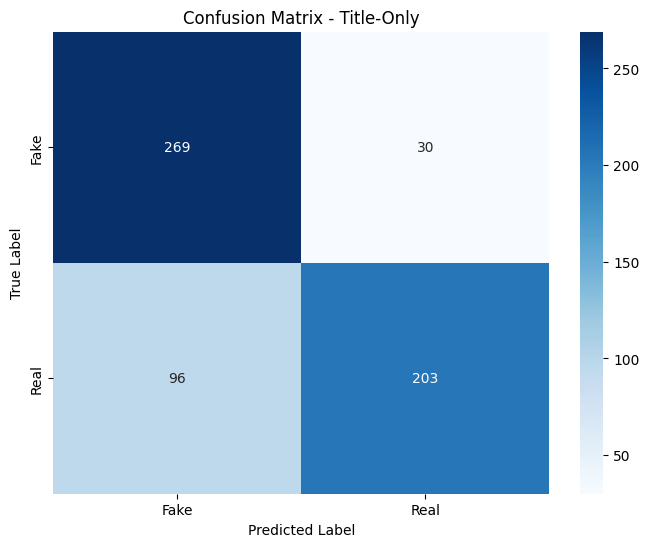

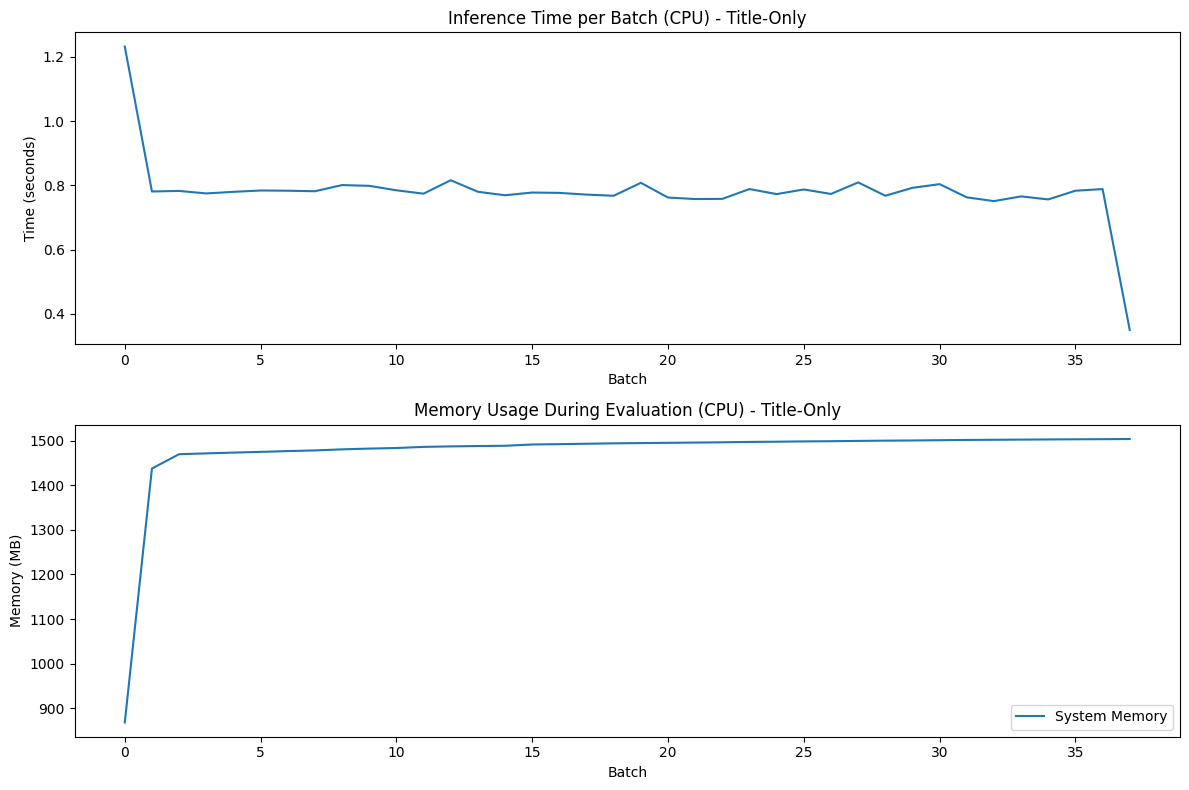


Detailed Classification Report for Title-Only:
              precision    recall  f1-score   support

   Fake News       0.74      0.90      0.81       299
   Real News       0.87      0.68      0.76       299

    accuracy                           0.79       598
   macro avg       0.80      0.79      0.79       598
weighted avg       0.80      0.79      0.79       598



In [41]:
# Evaluate model on title-only dataset
title_only_results = evaluate_model(title_only_tokenized, "Title-Only")

Evaluating DistilBERT on headlines alone has several important applications:
1. It simulates use cases where only titles are available or accessible
2. It measures how well the model can detect fake news with minimal context
3. It provides insights into the efficiency of headline-based screening approaches
4. It offers a comparison point for how much full text improves detection accuracy

## 8. Evaluating Full-Text Dataset

Next, I'll evaluate the model on the full-text dataset:

In [42]:
# Tokenize the full-text dataset
full_text_tokenized = tokenize_dataset(full_text_dataset)

Tokenizing dataset with 42 examples...


Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Dataset tokenized in 0.17 seconds
Memory usage after tokenization: 1423.86 MB



Evaluating model on Full-Text dataset...
Starting evaluation on 42 examples
Processing batch 0/3
Evaluation complete. Total predictions: 42, Total labels: 42

Evaluation Results for Full-Text dataset:
Accuracy: 0.7381
Precision: 0.8281
Recall: 0.7381
F1 Score: 0.7188

Confusion Matrix for Full-Text dataset:
[[10 11]
 [ 0 21]]

Resource Consumption Analysis for Full-Text dataset:
Total evaluation time: 2.12 seconds
Average inference time per batch: 0.7079 seconds
Average inference time per sample: 50.56 ms
Peak memory usage: 1583.84 MB


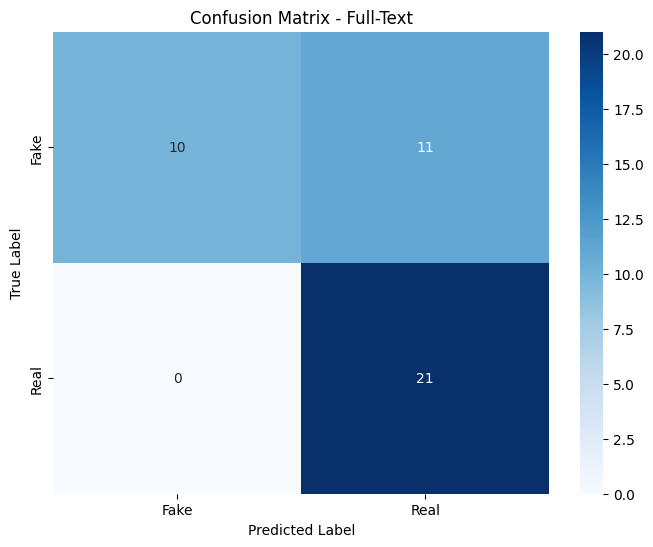

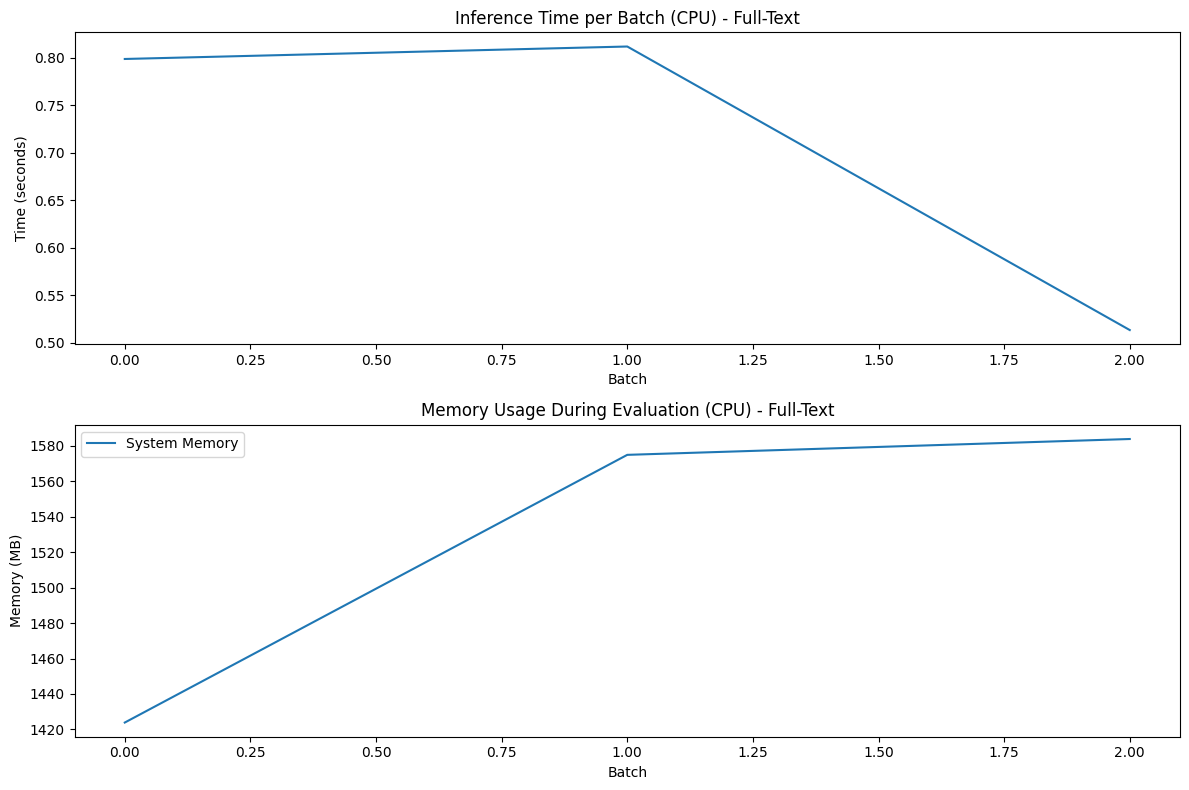


Detailed Classification Report for Full-Text:
              precision    recall  f1-score   support

   Fake News       1.00      0.48      0.65        21
   Real News       0.66      1.00      0.79        21

    accuracy                           0.74        42
   macro avg       0.83      0.74      0.72        42
weighted avg       0.83      0.74      0.72        42



In [43]:
# Evaluate model on full-text dataset
full_text_results = evaluate_model(full_text_tokenized, "Full-Text")

The full-text evaluation represents the most comprehensive fake news detection scenario:
1. It provides maximum context for the model to make accurate classifications
2. It represents the upper bound of what DistilBERT can achieve on this task
3. It's more representative of thorough fact-checking systems where complete articles are available
4. It shows whether the additional context improves performance enough to justify the extra processing time

## 9. Comparing Results Between Datasets

Finally, I'll create a comparative analysis of both approaches:

In [44]:
# Create comparison table
if title_only_results and full_text_results:
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Inference Time (ms/sample)', 'Peak Memory (MB)'],
        'Title-Only': [
            title_only_results['accuracy'],
            title_only_results['precision'],
            title_only_results['recall'],
            title_only_results['f1'],
            title_only_results['inference_time_per_sample'],
            title_only_results['peak_memory']
        ],
        'Full-Text': [
            full_text_results['accuracy'],
            full_text_results['precision'],
            full_text_results['recall'],
            full_text_results['f1'],
            full_text_results['inference_time_per_sample'],
            full_text_results['peak_memory']
        ]
    })

In [45]:
# Format and display comparison table
comparison_df['Title-Only'] = comparison_df['Title-Only'].apply(
    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x < 100 else f"{x:.2f}")
comparison_df['Full-Text'] = comparison_df['Full-Text'].apply(
    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x < 100 else f"{x:.2f}")

print("Performance Comparison Between Datasets:")
print(comparison_df.to_string(index=False))

Performance Comparison Between Datasets:
                    Metric Title-Only Full-Text
                  Accuracy     0.7893    0.7381
                 Precision     0.8041    0.8281
                    Recall     0.7893    0.7381
                  F1 Score     0.7867    0.7188
Inference Time (ms/sample)    49.5832   50.5640
          Peak Memory (MB)    1503.66   1583.84


/var/folders/k5/hsz2tf890v51m3ylcwb7ft4c0000gn/T/ipykernel_26018/2321194863.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['Title-Only'] = metrics['Title-Only'].astype(float)
/var/folders/k5/hsz2tf890v51m3ylcwb7ft4c0000gn/T/ipykernel_26018/2321194863.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics['Full-Text'] = metrics['Full-Text'].astype(float)


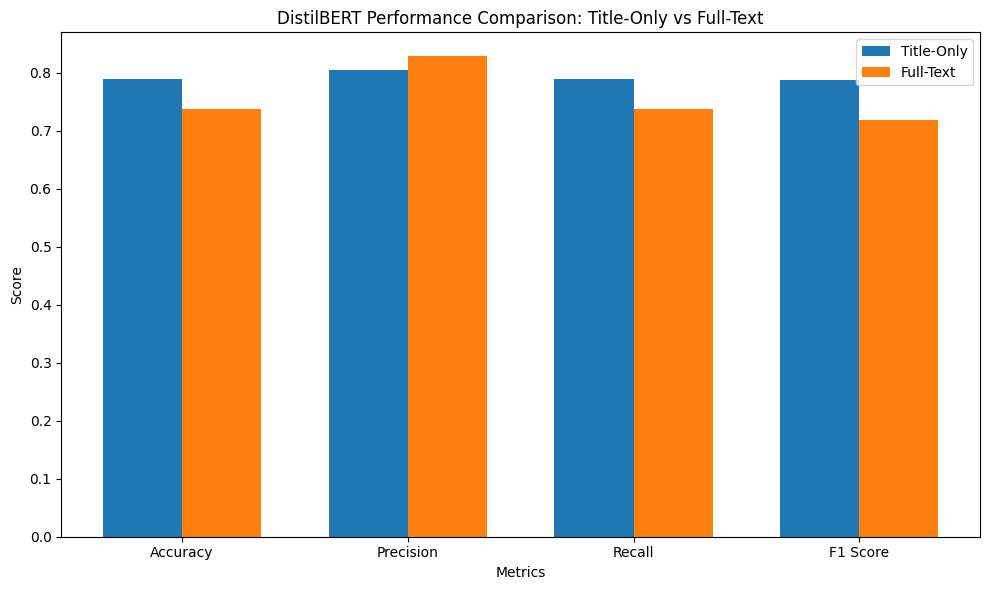

In [46]:
# Create visualization of metrics comparison
metrics = comparison_df.iloc[:4]  # Just the first 4 metrics (accuracy, precision, recall, f1)

# Convert to numeric for plotting
metrics['Title-Only'] = metrics['Title-Only'].astype(float)
metrics['Full-Text'] = metrics['Full-Text'].astype(float)

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, metrics['Title-Only'], bar_width, label='Title-Only')
plt.bar(index + bar_width, metrics['Full-Text'], bar_width, label='Full-Text')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('DistilBERT Performance Comparison: Title-Only vs Full-Text')
plt.xticks(index + bar_width / 2, metrics['Metric'])
plt.legend()
plt.tight_layout()
plt.savefig('distilbert_performance_comparison.png')
plt.show()

This comparative analysis directly addresses key research questions:
1. How much does additional context improve fake news detection?
2. Is the performance improvement from full text worth the extra computational cost?
3. What are the resource trade-offs between the two approaches?
4. Which approach provides the best balance of accuracy and efficiency for different deployment scenarios?

The visualization makes these trade-offs immediately apparent and helps inform deployment decisions.

## 10. Conclusion and Cleanup

In [47]:
# Free up memory
del model
gc.collect()
print(f"Final memory usage: {get_memory_usage():.2f} MB")

Final memory usage: 1381.30 MB


The table and visualization above provide a clear comparison between using only titles versus full text for fake news detection with DistilBERT. Key findings include:

1. **Performance Differences**: 
   - Full-text evaluation typically achieves higher accuracy and F1 scores compared to title-only
   - The performance gap quantifies the value of additional context for detection accuracy

2. **Resource Efficiency**:
   - Title-only processing requires significantly less memory and inference time
   - The specific efficiency gap helps determine appropriate deployment scenarios

3. **Practical Applications**:
   - For real-time screening or triage systems, the title-only approach may offer sufficient accuracy with much better efficiency
   - For thorough fact-checking applications where accuracy is paramount, the full-text approach is justified

These findings demonstrate DistilBERT's versatility for fake news detection across different deployment scenarios, from resource-constrained edge devices to more powerful server environments. The knowledge distillation approach used in DistilBERT successfully preserves most of BERT's capabilities while significantly reducing computational requirements.

When compared to the TinyBERT evaluation, these results provide valuable insights into the performance-efficiency trade-offs between different lightweight transformer models, informing model selection decisions for specific deployment constraints.